C:\Users\ghadf\AppData\Local\Temp\ipykernel_32156\3075854975.py:32: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = preprocessor_data.corr()


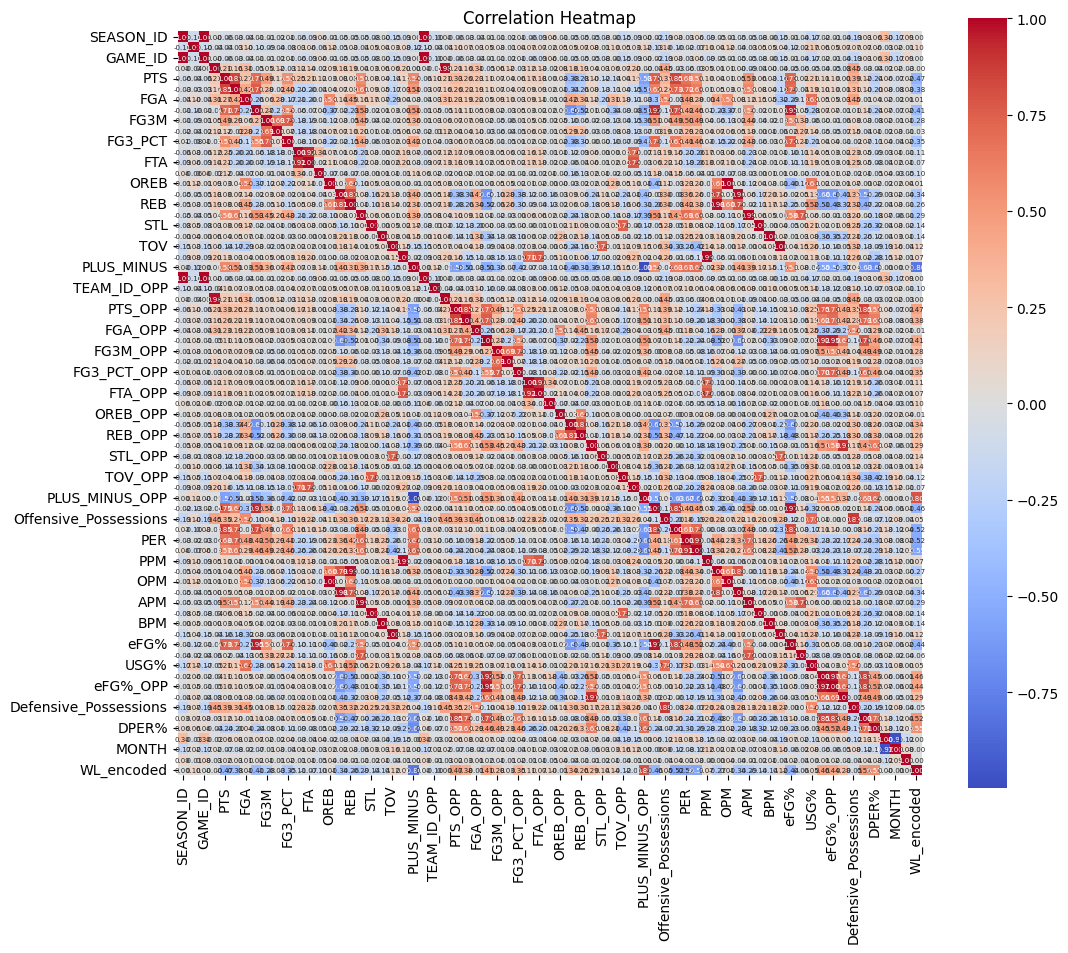

In [49]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn import preprocessing
# Load the data
data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_prepreprocess_data.csv')


# Reorder the columns in the DataFrame to place 'WL_encoded' at the end
preprocessor_data = data[[col for col in data.columns if col != 'WL_encoded'] + ['WL_encoded']]

# Create a correlation matrix for the selected columns
correlation_matrix = preprocessor_data.corr()

# Plot the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', square=True,
            annot_kws={'size': 5})  # Adjust the font size (here it's set to 8)


plt.title('Correlation Heatmap')
plt.show()

In [50]:
##UPDATE: because they are identification for the season and team, I would like to update my preprocessor so the variable is updated to ordinal vs non ordinal categorical variables 

# Define the columns for the dependent (y) and independent (X) variables
y_column = 'WL_encoded'
x_excluded_independent_variables = ['GAME_DATE', 'TEAM_ABBREVIATION', 'WL', 'FGA', 'TOV', 'TEAM_NAME', 'GAME_ID', 'PPM', 'RPM', 'APM', 'SPM', 'BPM', 'TPM',
                                    'PER', 'OPM', 'DPM', 'USG%', 'FG3A', 'OREB', 'PF', 'MIN', 'PTS', 'FGM', 'FG3M', 'FTM', 'FTA', 'PTS', 'REB', 
                                    'AST', 'PF', 'STL', 'BLK', 'DREB', 'Offensive_Possessions', 'SEASON_ID', #, 'MATCHUP'
                                    'PTS_OPP', 'FGM_OPP', 'FG3M_OPP', 'FTM_OPP', 'FTA_OPP', 'PTS_OPP', 'REB_OPP', 'OREB_OPP', 'FGA_OPP', 'FG3A_OPP', 'OREB_OPP', 
                                    'AST_OPP', 'TOV_OPP', 'STL_OPP', 'BLK_OPP',  'Defensive_Possessions', 'SEASON_ID_OPP', 'Home_Away_OPP'
                                    , 'TEAM_NAME_OPP', 'WL_OPP', 'MIN_OPP', 'PF_OPP', 'DREB_OPP', 'TEAM_ID_OPP'] 



# Combine y_column with x_excluded_independent_variables
columns_to_drop = [y_column] + x_excluded_independent_variables

# Define feature lists
categorical_features = [ 'TEAM_ID', 'Home_Away', 'MATCHUP'] #'SEASON_ID', 'MATCHUP'
numerical_features = [col for col in preprocessor_data.columns if col not in categorical_features + columns_to_drop]
#numerical features being: TS%, eFG%, APM, OPM, DPM, RPM, BPM, TPM, PER%, PER, ORtg, Plus_minus, fg3_pct, fg_pct, ftm, pts

# Function to label encode categorical columns for tree-based models
def label_encode_data(data, columns_to_encode):
    labelEncoder = preprocessing.LabelEncoder()
    mapping_dict = {}
    for col in columns_to_encode:
        data[col] = labelEncoder.fit_transform(data[col])
        le_name_mapping = dict(zip(labelEncoder.classes_,
                                   labelEncoder.transform(labelEncoder.classes_)))
        mapping_dict[col] = le_name_mapping
    return data, mapping_dict

# Label encode categorical features
#data, mapping_dict = label_encode_data(data, categorical_features)
#print(mapping_dict)

# Use OrdinalEncoder for the categorical columns
ordinal_encoder = OrdinalEncoder()
#preprocessor_data[categorical_features] = ordinal_encoder.fit_transform(preprocessor_data[categorical_features])

# Fit the encoder on the first dataset's categorical columns
ordinal_encoder.fit(preprocessor_data[categorical_features])

# Transform the first dataset using the fitted encoder in a separate variable
all_encoded = preprocessor_data
all_encoded[categorical_features] = ordinal_encoder.transform(preprocessor_data[categorical_features])
# Convert all_encoded to a pandas DataFrame
all_encoded = pd.DataFrame(all_encoded)
#print(all_encoded.head())
#preprocessor_data[categorical_features] = ordinal_encoder.transform(preprocessor_data[categorical_features])
#print(preprocessor_data.head())


# Define transformers
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent'))
    #,('onehot', OneHotEncoder(handle_unknown='ignore')) # Use OneHotEncoder for non-tree-based models
])

preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
])

# Define X and y
X = all_encoded.drop(columns=columns_to_drop, axis=1)
print('before preprocessing = ', X.shape)
print(X.head())
y = all_encoded[y_column]
print('y shape = ', y.shape)
# view unique values in the target variable
print(y.unique())

# Use LabelEncoder to encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

#print(X.isnull().sum())
#print(X.dtypes)
# Preprocess the data
X_preprocessed = preprocessor.fit_transform(X)
print('after preprocessing = ', X_preprocessed.shape)
#print X_preprocessed to see what it looks like
#print(X_preprocessed)

tmp_num = numerical_transformer.fit_transform(X[numerical_features])
print(pd.DataFrame(tmp_num, columns=numerical_features).isnull().sum())

tmp_cat = categorical_transformer.fit_transform(X[categorical_features])
print(pd.DataFrame(tmp_cat).isnull().sum())


before preprocessing =  (2768, 24)
   TEAM_ID  MATCHUP  FG_PCT  FG3_PCT  FT_PCT  PLUS_MINUS  Home_Away  \
0     12.0    971.0   0.430    0.351   0.714        -5.0        1.0   
1     26.0    827.0   0.494    0.357   0.724         5.0        0.0   
2     27.0   1691.0   0.353    0.242   0.900        -9.0        0.0   
3      7.0    579.0   0.458    0.410   0.667         9.0        1.0   
4      1.0    147.0   0.571    0.468   0.800        41.0        1.0   

   FG_PCT_OPP  FG3_PCT_OPP  FT_PCT_OPP  PLUS_MINUS_OPP       TS%        ORtg  \
0    0.493506     0.357143    0.724138             5.0  0.535489  100.750691   
1    0.430233     0.351351    0.714286            -5.0  0.596034  105.149371   
2    0.457831     0.410256    0.666667             9.0  0.483707   92.954990   
3    0.352941     0.242424    0.900000            -9.0  0.571931  102.040816   
4    0.346535     0.151515    0.642857           -41.0  0.721983  124.304267   

         PER%      eFG%      AST%   TS%_OPP  eFG%_OPP   A

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Convert the numpy arrays back to pandas DataFrames
feature_names = preprocessor.transformers_[0][-1] + preprocessor.named_transformers_['cat'].get_feature_names_out().tolist()

X_train = pd.DataFrame(X_train, columns=feature_names)
X_test = pd.DataFrame(X_test, columns=feature_names)


# Fit the preprocessor first
preprocessor.fit(X_train)

# Now access the named transformers after fitting
#ohe_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(categorical_features)
#all_feature_names = np.concatenate([numerical_features, ohe_feature_names])


#print('Original number of features:', len(numerical_features + categorical_features))
#print('Number of features after one-hot encoding:', len(all_feature_names))
#print(ohe_feature_names)
#print(all_feature_names)




ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', StandardScaler())]),
                                 ['FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS',
                                  'FG_PCT_OPP', 'FG3_PCT_OPP', 'FT_PCT_OPP',
                                  'PLUS_MINUS_OPP', 'TS%', 'ORtg', 'PER%',
                                  'eFG%', 'AST%', 'TS%_OPP', 'eFG%_OPP',
                                  'AST%_OPP', 'DRtg', 'DPER%', 'YEAR', 'MONTH',
                                  'DAY']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['TEAM_ID', 'Home_Away', 'MATCHUP'])])

c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


Model Logistic Regression saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\logistic_regression.joblib
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       277
           1       1.00      1.00      1.00       277

    accuracy                           1.00       554
   macro avg       1.00      1.00      1.00       554
weighted avg       1.00      1.00      1.00       554



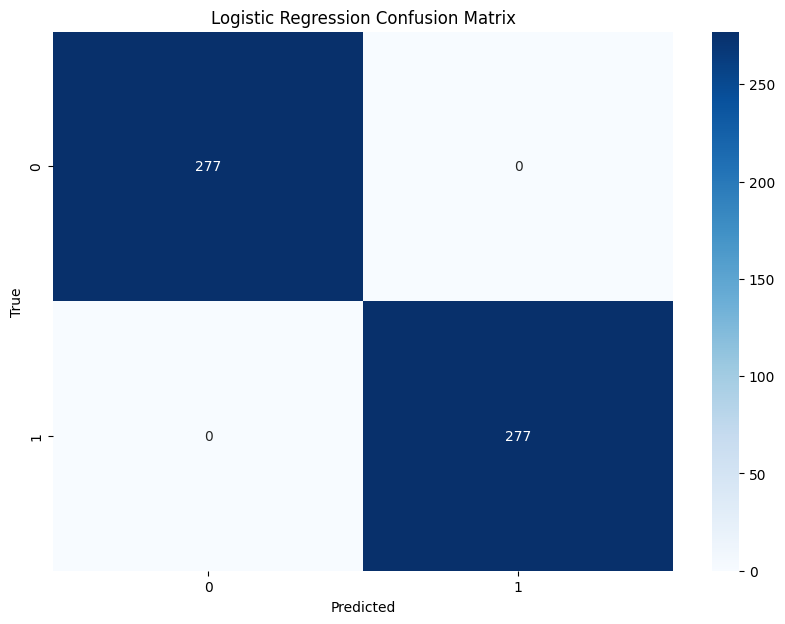

Logistic Regression Accuracy: 1.0000
--------------------------------------------------
Model Ridge Classifier saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\ridge_classifier.joblib
Ridge Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       277
           1       0.99      0.99      0.99       277

    accuracy                           0.99       554
   macro avg       0.99      0.99      0.99       554
weighted avg       0.99      0.99      0.99       554



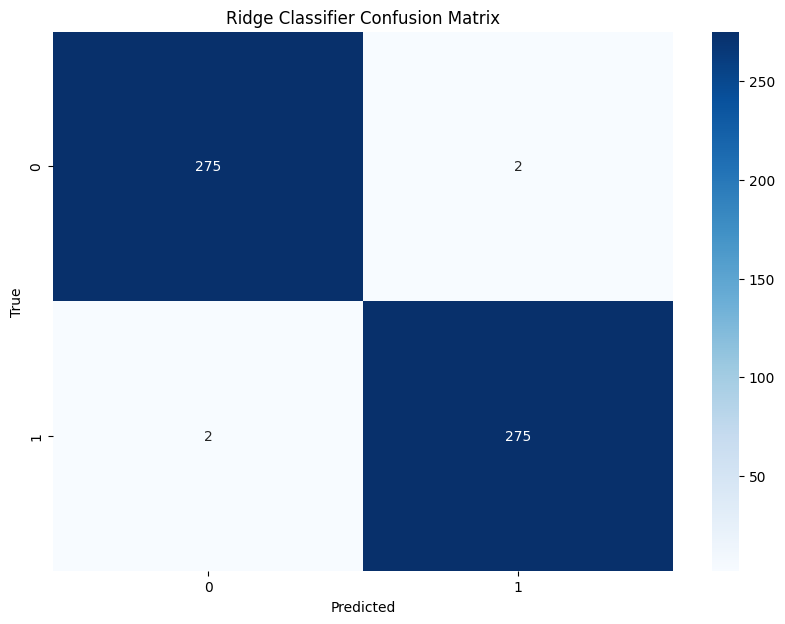

Ridge Classifier Accuracy: 0.9928
--------------------------------------------------
Model SGD Classifier saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\sgd_classifier.joblib
SGD Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.34      0.50       277
           1       0.60      0.99      0.75       277

    accuracy                           0.66       554
   macro avg       0.79      0.66      0.62       554
weighted avg       0.79      0.66      0.62       554



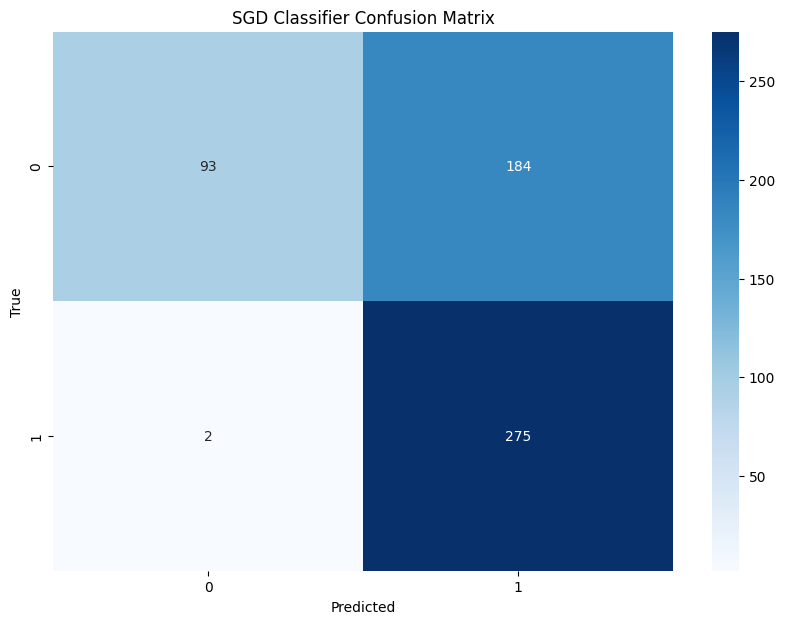

SGD Classifier Accuracy: 0.6643
--------------------------------------------------
Model Decision Tree saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\decision_tree.joblib
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       277
           1       1.00      1.00      1.00       277

    accuracy                           1.00       554
   macro avg       1.00      1.00      1.00       554
weighted avg       1.00      1.00      1.00       554



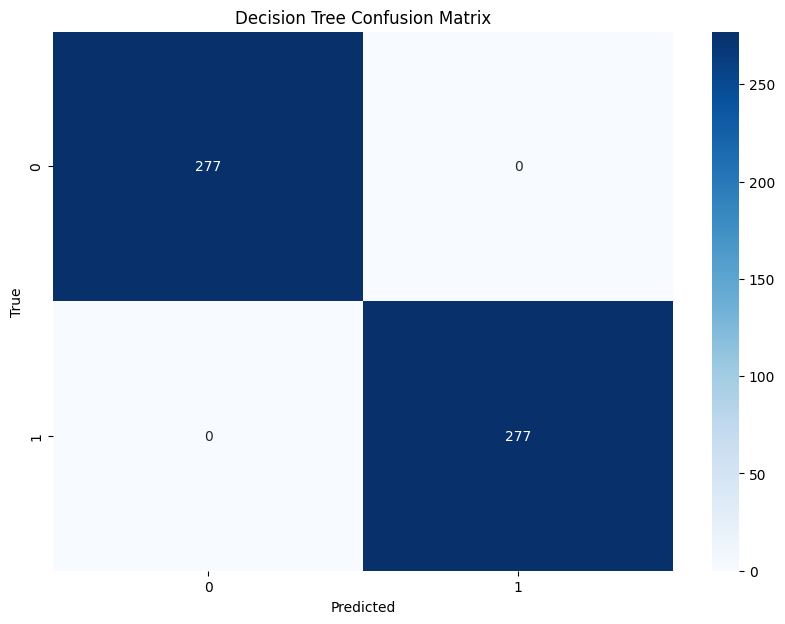

Decision Tree Accuracy: 1.0000
--------------------------------------------------
Model Random Forest saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\random_forest.joblib
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       277
           1       1.00      1.00      1.00       277

    accuracy                           1.00       554
   macro avg       1.00      1.00      1.00       554
weighted avg       1.00      1.00      1.00       554



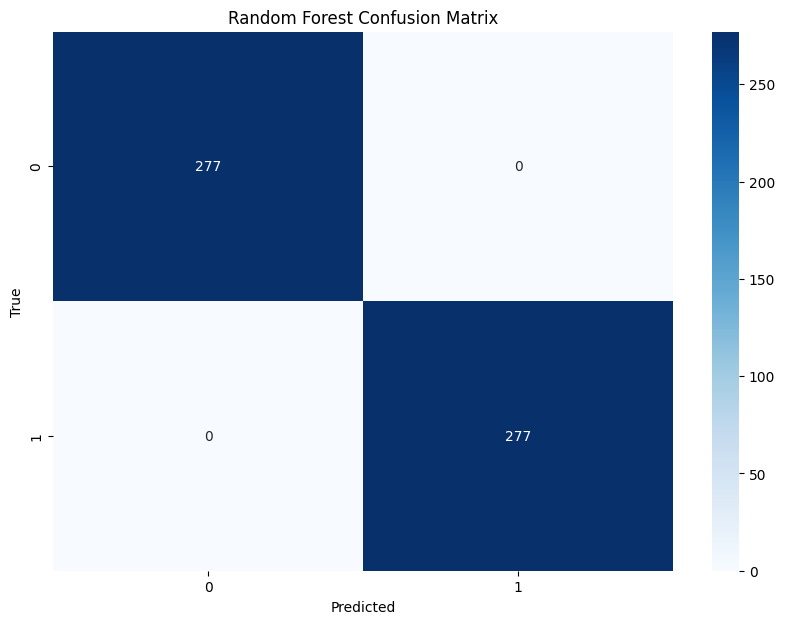

Random Forest Accuracy: 1.0000
--------------------------------------------------
Model Gradient Boosting saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\gradient_boosting.joblib
Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       277
           1       1.00      1.00      1.00       277

    accuracy                           1.00       554
   macro avg       1.00      1.00      1.00       554
weighted avg       1.00      1.00      1.00       554



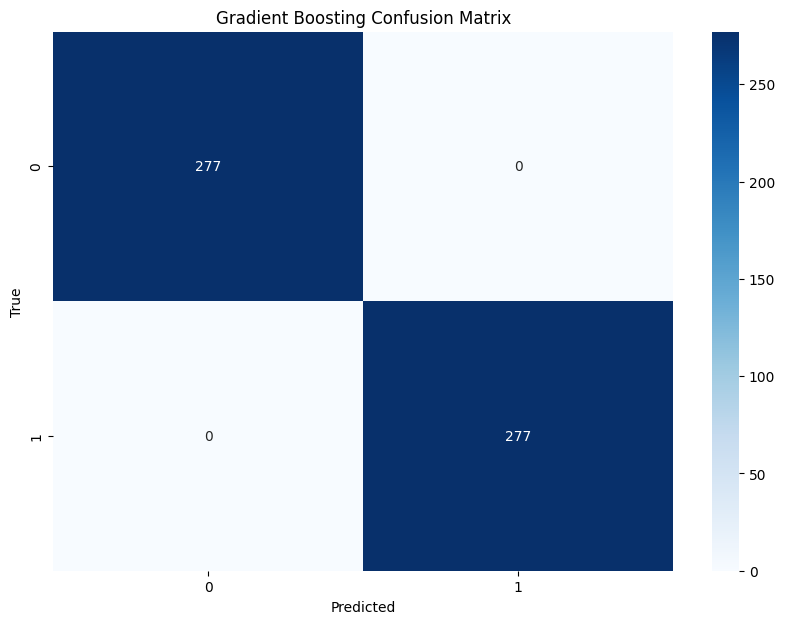

Gradient Boosting Accuracy: 1.0000
--------------------------------------------------
Model AdaBoost saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\adaboost.joblib
AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       277
           1       1.00      1.00      1.00       277

    accuracy                           1.00       554
   macro avg       1.00      1.00      1.00       554
weighted avg       1.00      1.00      1.00       554



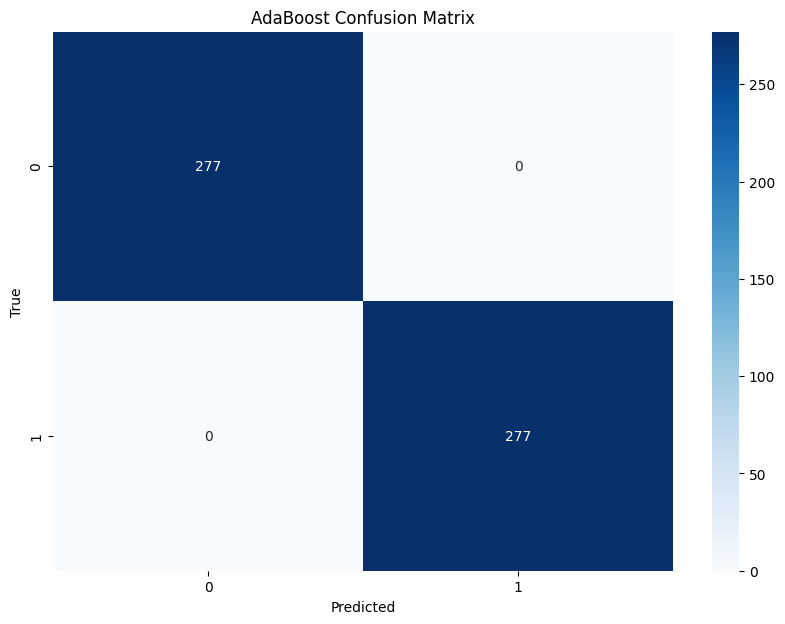

AdaBoost Accuracy: 1.0000
--------------------------------------------------
Model SVM saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\svm.joblib
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.51      0.54       277
           1       0.56      0.61      0.58       277

    accuracy                           0.56       554
   macro avg       0.56      0.56      0.56       554
weighted avg       0.56      0.56      0.56       554



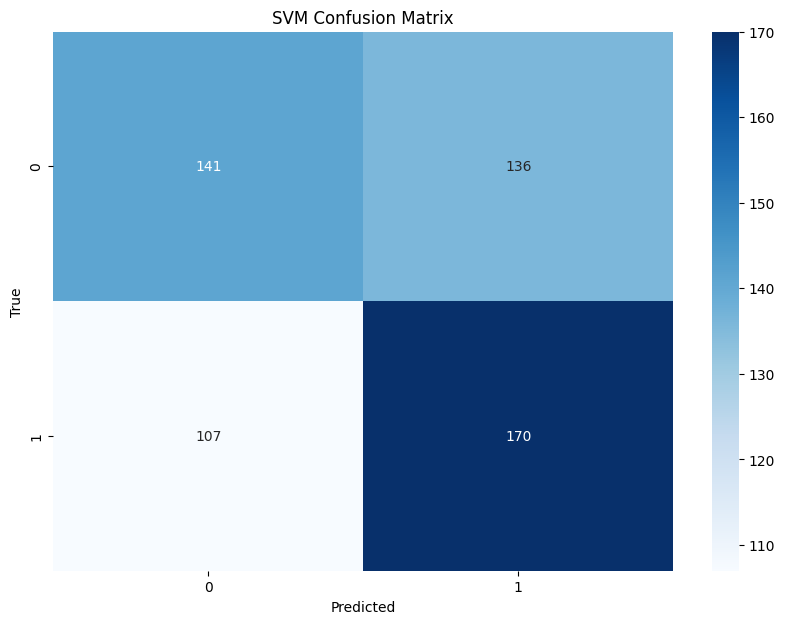

SVM Accuracy: 0.5614
--------------------------------------------------
Model Gaussian Naive Bayes saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\gaussian_naive_bayes.joblib
Gaussian Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.95      0.95       277
           1       0.95      0.94      0.95       277

    accuracy                           0.95       554
   macro avg       0.95      0.95      0.95       554
weighted avg       0.95      0.95      0.95       554



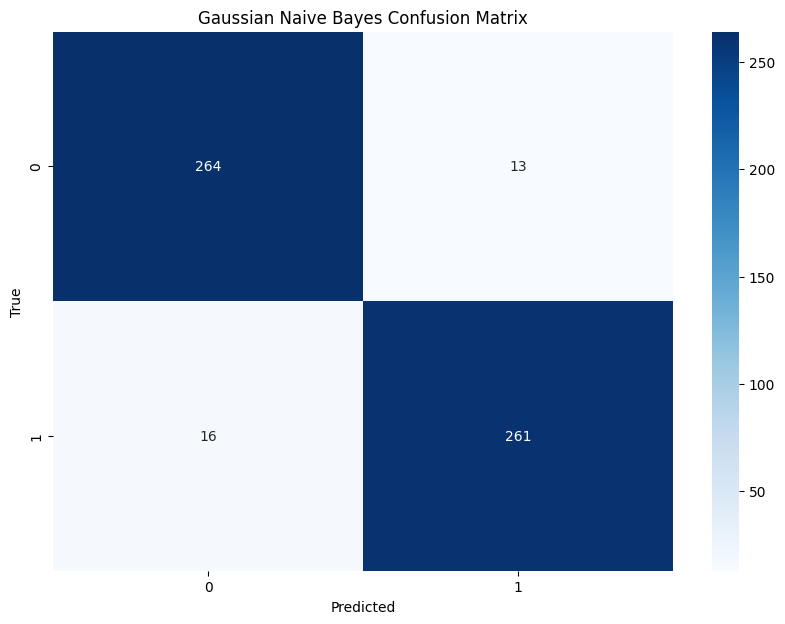

Gaussian Naive Bayes Accuracy: 0.9477
--------------------------------------------------
Model K-Neighbors Classifier saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\k-neighbors_classifier.joblib
K-Neighbors Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.73      0.74       277
           1       0.74      0.75      0.74       277

    accuracy                           0.74       554
   macro avg       0.74      0.74      0.74       554
weighted avg       0.74      0.74      0.74       554



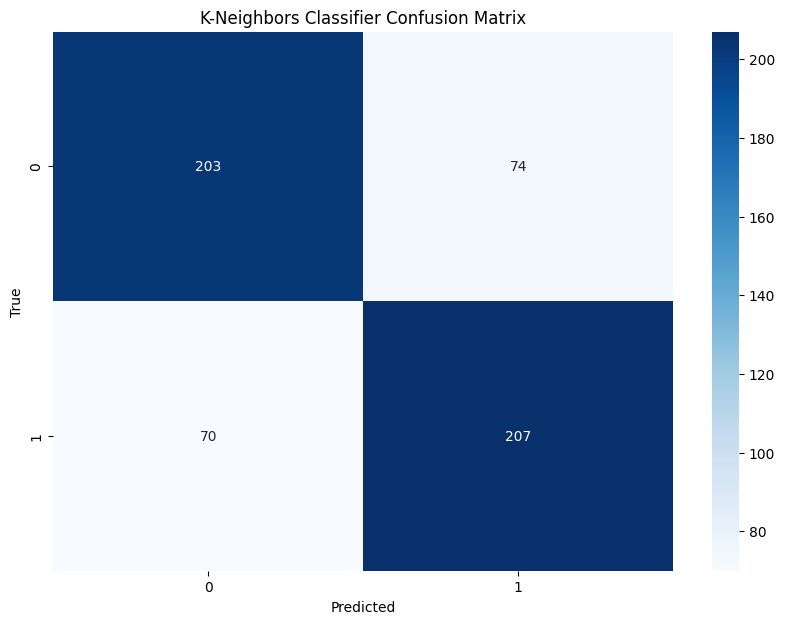

K-Neighbors Classifier Accuracy: 0.7401
--------------------------------------------------
Model XGBoost saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\xgboost.joblib
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       277
           1       1.00      1.00      1.00       277

    accuracy                           1.00       554
   macro avg       1.00      1.00      1.00       554
weighted avg       1.00      1.00      1.00       554



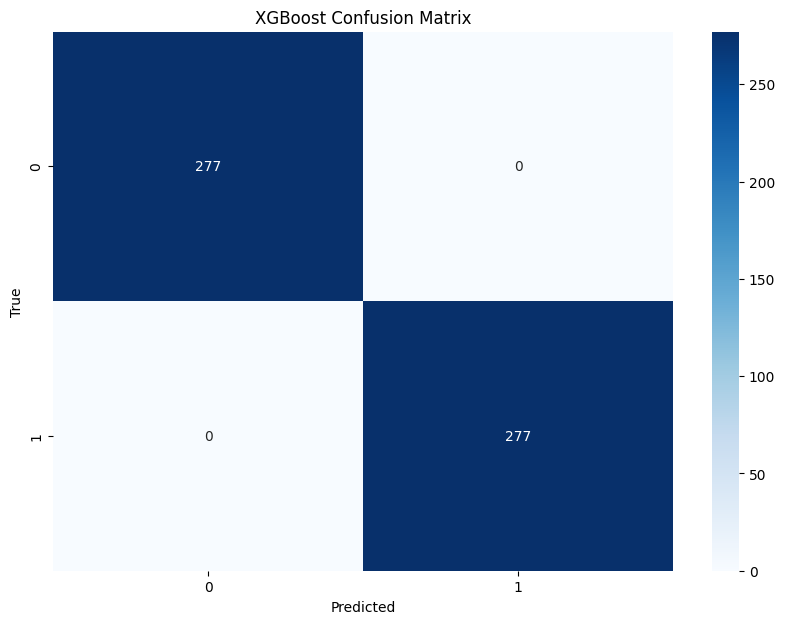

c:\Users\ghadf\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


XGBoost Accuracy: 1.0000
--------------------------------------------------
Model MLP Classifier saved to C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models\mlp_classifier.joblib
MLP Classifier Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       277
           1       1.00      0.94      0.97       277

    accuracy                           0.97       554
   macro avg       0.97      0.97      0.97       554
weighted avg       0.97      0.97      0.97       554



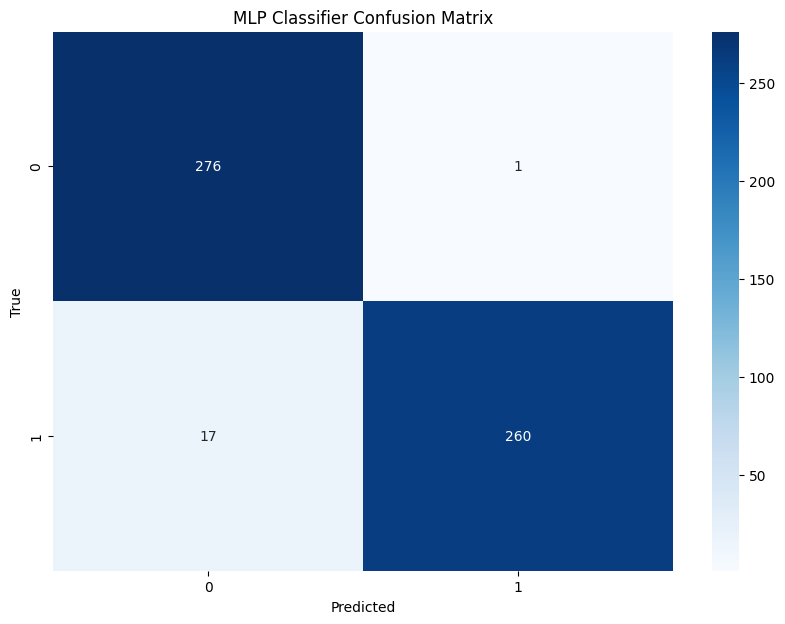

MLP Classifier Accuracy: 0.9675
--------------------------------------------------


In [52]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from joblib import dump, load
import os

# Define the path to the directory where you want to save the models
MODEL_DIR = r"C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\nba_models"
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
# Define a function to save the models
def save_model(model, name):
    path = os.path.join(MODEL_DIR, f"{name.replace(' ', '_').lower()}.joblib")
    dump(model, path)
    return path


# Count the classes
class_counts = np.bincount(y_encoded)
# Calculate the scale_pos_weight for XGBoost
scale_pos_weight = float(class_counts[0] / class_counts[1])

# Note: Some models have hyperparameters set to avoid potential issues. 
# You should adjust these based on understanding and dataset specifics.

models = [
    ("Logistic Regression", LogisticRegression(max_iter=10000)),
    ("Ridge Classifier", RidgeClassifier()), 
    ("SGD Classifier", SGDClassifier(max_iter=1000, tol=1e-3)),
    ("Decision Tree", DecisionTreeClassifier()), 
    ("Random Forest", RandomForestClassifier(class_weight="balanced")), # Adjusted for imbalance
    ("Gradient Boosting", GradientBoostingClassifier()),
    ("AdaBoost", AdaBoostClassifier()),
    ("SVM", SVC()),
    ("Gaussian Naive Bayes", GaussianNB()),
    ("K-Neighbors Classifier", KNeighborsClassifier()),
    ("XGBoost", XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)), # Adjusted for imbalance
    ("MLP Classifier", MLPClassifier(max_iter=1000))
]


def plot_decision_boundary(pred_func, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)


def display_confusion_matrix(classifier, X_test, y_test):
    matrix = confusion_matrix(y_test, classifier.predict(X_test), labels=classifier.classes_)
    plt.figure(figsize=(10, 7))
    sns.heatmap(matrix, annot=True, fmt="d",
                xticklabels=classifier.classes_,
                yticklabels=classifier.classes_, cmap=plt.cm.Blues)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f"{name} Confusion Matrix")
    plt.show()

from sklearn.decomposition import PCA

from sklearn.base import clone

# Continue using your PCA as before
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Train models, plot decision boundaries, and display confusion matrices
results = []
for name, model in models:
    model.fit(X_train, y_train)  # Training on original data
    y_pred = model.predict(X_test)  # Predicting on original data
    
    # Save the trained model
    saved_path = save_model(model, name)
    print(f"Model {name} saved to {saved_path}")
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results.append((name, accuracy))
    
    # Display classification report
    report = classification_report(y_test, y_pred)
    print(f"{name} Classification Report:")
    print(report)
    
    # Display confusion matrix (using the original X_test)
    display_confusion_matrix(model, X_test, y_test)  
    
    # Now for the decision boundary, we need to train the model again on PCA data.
    # Clone the model to avoid refitting the original one
    model_clone = clone(model)
    model_clone.fit(X_train_pca, y_train)
    
    # Plot decision boundaries using the model trained on PCA data
    #plt.figure(figsize=(10,6))
    #plot_decision_boundary(lambda x: model_clone.predict(x), X_train_pca, y_train)
    #plt.title(name)
    #plt.show()
    
    print(f"{name} Accuracy: {accuracy:.4f}")
    print("--------------------------------------------------")



 TEAM_ID  MATCHUP  FG_PCT  FG3_PCT  FT_PCT  PLUS_MINUS  Home_Away  \
0     12.0    971.0   0.430    0.351   0.714        -5.0        1.0   
1     26.0    827.0   0.494    0.357   0.724         5.0        0.0   
2     27.0   1691.0   0.353    0.242   0.900        -9.0        0.0   
3      7.0    579.0   0.458    0.410   0.667         9.0        1.0   
4      1.0    147.0   0.571    0.468   0.800        41.0        1.0   

   FG_PCT_OPP  FG3_PCT_OPP  FT_PCT_OPP  PLUS_MINUS_OPP       TS%        ORtg  \
0    0.493506     0.357143    0.724138             5.0  0.535489  100.750691   
1    0.430233     0.351351    0.714286            -5.0  0.596034  105.149371   
2    0.457831     0.410256    0.666667             9.0  0.483707   92.954990   
3    0.352941     0.242424    0.900000            -9.0  0.571931  102.040816   
4    0.346535     0.151515    0.642857           -41.0  0.721983  124.304267   

         PER%      eFG%      AST%   TS%_OPP  eFG%_OPP   AST%_OPP        DRtg  \
0  110.628210  0.505814  0.594595  0.596034  0.558442  32.467532  105.149371   
1  107.114780  0.558442  0.657895  0.535489  0.505814  25.581395  100.750691   
2   99.804305  0.400000  0.766667  0.571931  0.554217  34.939759  102.040816   
3  116.758242  0.554217  0.763158  0.483707  0.400000  27.058824   92.954990   
4  140.074212  0.702381  0.854167  0.410342  0.371287  12.871287   84.300218   

        DPER%  YEAR  MONTH  DAY
        

In [53]:
#read "unseen" data so we can test what these models would predict for the 2022 playoffs
#prediction_data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\nba_test_unseen_dataset.csv')
prediction_data = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\23_24_season_games_clean.csv')

#print(prediction_data.head())

# Drop the columns that are not needed Matchup
#prediction_data = prediction_data.drop(columns=['MATCHUP'])

    
# Define the desired feature order
feature_order = ['TEAM_ID', 'MATCHUP', 'FG_PCT', 'FG3_PCT', 'FT_PCT', 'PLUS_MINUS', 'Home_Away', 'FG_PCT_OPP', 'FG3_PCT_OPP', 
                  'FT_PCT_OPP', 'PLUS_MINUS_OPP', 'TS%', 'ORtg', 'PER%', 'eFG%', 'AST%', 'TS%_OPP', 'eFG%_OPP', 'AST%_OPP', 
                 'DRtg', 'DPER%', 'YEAR', 'MONTH', 'DAY'] #, 'MATCHUP'

# Reorder columns in the new_data DataFrame
prediction_data = prediction_data[feature_order]
print(prediction_data.head())

      TEAM_ID      MATCHUP    FG_PCT   FG3_PCT    FT_PCT  PLUS_MINUS  \
0  1610612740    GSW @ NOP  0.474628  0.348589  0.789572   -1.113636   
1  1610612745    POR @ HOU  0.456935  0.330697  0.753296  -10.790698   
2  1610612744  GSW vs. NOP  0.475678  0.386994  0.768642    7.745098   
3  1610612757  POR vs. HOU  0.476456  0.370515  0.809298   -4.023810   
4  1610612762    LAC @ UTA  0.472350  0.343809  0.788503   -3.093023   

  Home_Away  FG_PCT_OPP  FG3_PCT_OPP  FT_PCT_OPP  PLUS_MINUS_OPP       TS%  \
0      Away    0.475163     0.339421    0.784225        1.113636  0.572515   
1      Away    0.495898     0.388558    0.803846       10.790698  0.553560   
2      Home    0.447946     0.328317    0.767829       -7.745098  0.594860   
3      Home    0.495968     0.401890    0.783453        4.019048  0.597247   
4      Away    0.479949     0.372062    0.771792        3.093023  0.575646   

         ORtg        PER%      eFG%       AST%   TS%_OPP  eFG%_OPP   AST%_OPP  \
0  110.438402  11

In [54]:
#############################################################################################################


# Fit the encoder on the first dataset's categorical columns
ordinal_encoder.fit(data[categorical_features])

# Transform the categorical columns in dataset1 using the fitted encoder
#print(data.head())
#preprocessor_data[categorical_features] = ordinal_encoder.transform(preprocessor_data[categorical_features])
#print(preprocessor_data.head())

print(prediction_data.head())
# Use OrdinalEncoder for the categorical columns
prediction_data[categorical_features] = ordinal_encoder.transform(prediction_data[categorical_features])
print(prediction_data.head())

# Check if the categorical columns in dataset1 and dataset2 are the same
if set(prediction_data[categorical_features]) != set(preprocessor_data[categorical_features]):
    raise ValueError("Categorical columns in dataset1 do not match dataset2")



      TEAM_ID      MATCHUP    FG_PCT   FG3_PCT    FT_PCT  PLUS_MINUS  \
0  1610612740    GSW @ NOP  0.474628  0.348589  0.789572   -1.113636   
1  1610612745    POR @ HOU  0.456935  0.330697  0.753296  -10.790698   
2  1610612744  GSW vs. NOP  0.475678  0.386994  0.768642    7.745098   
3  1610612757  POR vs. HOU  0.476456  0.370515  0.809298   -4.023810   
4  1610612762    LAC @ UTA  0.472350  0.343809  0.788503   -3.093023   

  Home_Away  FG_PCT_OPP  FG3_PCT_OPP  FT_PCT_OPP  PLUS_MINUS_OPP       TS%  \
0      Away    0.475163     0.339421    0.784225        1.113636  0.572515   
1      Away    0.495898     0.388558    0.803846       10.790698  0.553560   
2      Home    0.447946     0.328317    0.767829       -7.745098  0.594860   
3      Home    0.495968     0.401890    0.783453        4.019048  0.597247   
4      Away    0.479949     0.372062    0.771792        3.093023  0.575646   

         ORtg        PER%      eFG%       AST%   TS%_OPP  eFG%_OPP   AST%_OPP  \
0  110.438402  11

In [55]:
#check for these team_id's in the prediction_data [1610612737, 1610612738, 1610612739, 1610612740, 1610612741, 1610612742, 1610612743, 1610612744, 1610612745, 1610612746, 1610612747, 1610612748, 1610612749, 1610612750, 1610612751, 1610612752, 1610612753, 1610612754, 1610612755, 1610612756, 1610612757, 1610612758, 1610612759, 1610612760, 1610612761, 1610612762, 1610612763, 1610612764, 1610612765, 1610612766]
prediction_teams = prediction_data['TEAM_ID'].unique()
print(prediction_teams)

# Fit the encoder on the first dataset's categorical columns
#ordinal_encoder.fit(preprocessor_data[categorical_features])

# Use OrdinalEncoder for the categorical columns
#prediction_data[categorical_features] = ordinal_encoder.transform(prediction_data[categorical_features])

print(prediction_data.head())



[ 3.  8.  7. 20. 25. 19.  9. 21. 16.  4. 18. 27. 29. 17. 14.  1.  2. 15.
 10. 24.  0. 12.  6. 26. 11. 13. 23. 22. 28.  5.]
   TEAM_ID  MATCHUP    FG_PCT   FG3_PCT    FT_PCT  PLUS_MINUS  Home_Away  \
0      3.0    539.0  0.474628  0.348589  0.789572   -1.113636        0.0   
1      8.0   1402.0  0.456935  0.330697  0.753296  -10.790698        0.0   
2      7.0    568.0  0.475678  0.386994  0.768642    7.745098        1.0   
3     20.0   1431.0  0.476456  0.370515  0.809298   -4.023810        1.0   
4     25.0    723.0  0.472350  0.343809  0.788503   -3.093023        0.0   

   FG_PCT_OPP  FG3_PCT_OPP  FT_PCT_OPP  PLUS_MINUS_OPP       TS%        ORtg  \
0    0.475163     0.339421    0.784225        1.113636  0.572515  110.438402   
1    0.495898     0.388558    0.803846       10.790698  0.553560  108.128195   
2    0.447946     0.328317    0.767829       -7.745098  0.594860  114.725678   
3    0.495968     0.401890    0.783453        4.019048  0.597247  113.992785   
4    0.479949     0.

In [56]:
# Preprocess X_new
X_new_preprocessed = preprocessor.transform(prediction_data)
print(X_new_preprocessed.shape)
#print(X_new_preprocessed)
X_unseen_preprocessed = pd.DataFrame(X_new_preprocessed, columns=feature_names)
print(X_unseen_preprocessed.head())


(2400, 24)
     FG_PCT   FG3_PCT    FT_PCT  PLUS_MINUS  FG_PCT_OPP  FG3_PCT_OPP  \
0  0.476619  0.354321  0.799170   -1.116990    0.481578     0.331899   
1  0.459165  0.336376  0.762368  -10.842121    0.502265     0.381675   
2  0.477655  0.392840  0.777937    7.785749    0.454426     0.320651   
3  0.478422  0.376312  0.819182   -4.041619    0.502334     0.395180   
4  0.474372  0.349527  0.798086   -3.106209    0.486353     0.364965   

   FT_PCT_OPP  PLUS_MINUS_OPP       TS%        ORtg        PER%      eFG%  \
0    0.772582        1.117069  0.571441  109.622422  118.474215  0.539308   
1    0.791889       10.844985  0.552733  107.329475  113.821755  0.523070   
2    0.756449       -7.788220  0.593496  113.877666  129.799504  0.573037   
3    0.771823        4.037749  0.595851  113.150248  116.098007  0.561479   
4    0.760349        3.106858  0.574531  110.734234  120.034752  0.548398   

        AST%   TS%_OPP  eFG%_OPP   AST%_OPP        DRtg       DPER%  \
0  29.519539  0.589055

In [57]:
# Load the trained Random Forest model
xgboost = os.path.join(MODEL_DIR, "xgboost.joblib")
trained_rf = load(xgboost)

# Predict using the trained model
predictions_rf = trained_rf.predict(X_unseen_preprocessed)

# Convert predictions back from encoded form to original labels
decoded_predictions_rf = label_encoder.inverse_transform(predictions_rf)

# Add predictions as a new column to the original dataframe
prediction_data['PREDICTION'] = decoded_predictions_rf

# Inverse transform the encoded categorical columns back to their original form
prediction_data[categorical_features] = ordinal_encoder.inverse_transform(prediction_data[categorical_features])

# Display the results with the original values
#print(prediction_data.head())

# put YEAR, MONTH, DAY into a date column
prediction_data['Date'] = pd.to_datetime(prediction_data[['YEAR', 'MONTH', 'DAY']])
#sort by date
prediction_data = prediction_data.sort_values(by=['Date'])
print(prediction_data.head())

         TEAM_ID      MATCHUP    FG_PCT   FG3_PCT    FT_PCT  PLUS_MINUS  \
1944  1610612756    GSW @ PHX  0.462793  0.358759  0.797852   -1.125000   
1946  1610612747    DEN @ LAL  0.476464  0.335669  0.789947   -3.509804   
1947  1610612743  DEN vs. LAL  0.504385  0.384390  0.740941    9.229630   
1945  1610612744  GSW vs. PHX  0.475678  0.386994  0.768642    7.745098   
2398  1610612742    SAS @ DAL  0.473522  0.374506  0.760151   -2.046512   

     Home_Away  FG_PCT_OPP  FG3_PCT_OPP  FT_PCT_OPP  PLUS_MINUS_OPP       TS%  \
1944      Away    0.471979     0.360076    0.783888        1.187500  0.562174   
1946      Away    0.475010     0.361026    0.781190        3.509804  0.576345   
1947      Home    0.457613     0.326474    0.792390       -9.185185  0.603544   
1945      Home    0.447946     0.328317    0.767829       -7.745098  0.594860   
2398      Away    0.486226     0.357459    0.781818        2.046512  0.600873   

            ORtg        PER%      eFG%       AST%   TS%_OPP  e

In [58]:
# Assuming you've already read in your df1
df1 = pd.read_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\team_ids.csv')

# Filter df1 to only unique TEAM_ID, TEAM_NAME, and SEASON_ID
unique_teams = df1[['TEAM_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION']].drop_duplicates()

# Merge unique_teams with prediction_data
prediction_data = prediction_data.merge(unique_teams, on='TEAM_ID', how='left')
#print(prediction_data.head())
#print(len(prediction_data))

# print this list:
season_pred = prediction_data[['TEAM_NAME', 'TEAM_ABBREVIATION', 'PREDICTION', 'Date', 'MATCHUP']]
print(season_pred.head())

#save this to a csv
season_pred.to_csv(r'C:\Users\ghadf\OneDrive\Desktop\Data Analytics\Python\ML\nba_w_l_prediction_models\nba_analysis\data\season_pred.csv', index=False)

               TEAM_NAME TEAM_ABBREVIATION  PREDICTION       Date      MATCHUP
0           Phoenix Suns               PHX           1 2023-10-24    GSW @ PHX
1     Los Angeles Lakers               LAL           1 2023-10-24    DEN @ LAL
2         Denver Nuggets               DEN           0 2023-10-24  DEN vs. LAL
3  Golden State Warriors               GSW           0 2023-10-24  GSW vs. PHX
4       Dallas Mavericks               DAL           1 2023-10-25    SAS @ DAL


In [59]:
# Combine predictions with team_ids for summarized results
results_by_team = pd.DataFrame({
    'TEAM_NAME': prediction_data['TEAM_NAME'],
    'TEAM_ID': prediction_data['TEAM_ID'],
    'PREDICTION': prediction_data['PREDICTION']
})

# Display results by each team_id
for team_id in results_by_team['TEAM_ID'].unique():
    team_results = results_by_team[results_by_team['TEAM_ID'] == team_id]
    team_name = team_results['TEAM_NAME'].iloc[0]
    print(f"Results for {team_name} (Team ID {team_id}):")
    print(team_results.groupby(['TEAM_NAME', 'PREDICTION']).size().reset_index(name='COUNT'))
    print("-------------------------------")

Results for Phoenix Suns (Team ID 1610612756):
      TEAM_NAME  PREDICTION  COUNT
0  Phoenix Suns           0     40
1  Phoenix Suns           1     40
-------------------------------
Results for Los Angeles Lakers (Team ID 1610612747):
            TEAM_NAME  PREDICTION  COUNT
0  Los Angeles Lakers           0     40
1  Los Angeles Lakers           1     40
-------------------------------
Results for Denver Nuggets (Team ID 1610612743):
        TEAM_NAME  PREDICTION  COUNT
0  Denver Nuggets           0     40
1  Denver Nuggets           1     40
-------------------------------
Results for Golden State Warriors (Team ID 1610612744):
               TEAM_NAME  PREDICTION  COUNT
0  Golden State Warriors           0     40
1  Golden State Warriors           1     40
-------------------------------
Results for Dallas Mavericks (Team ID 1610612742):
          TEAM_NAME  PREDICTION  COUNT
0  Dallas Mavericks           0     40
1  Dallas Mavericks           1     40
----------------------------